In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.shape


(5110, 12)

In [2]:
df.isna().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [3]:
df=df.drop(['id'], axis=1)
df=df.dropna(subset = ["bmi"])
df=df.drop(df[df["gender"]=="Other"].index)
df['age']=df['age'].astype('int')
df=df.drop(df[(df["stroke"]==1)& (df["age"]<10)].index)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4908 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4908 non-null   object 
 1   age                4908 non-null   int32  
 2   hypertension       4908 non-null   int64  
 3   heart_disease      4908 non-null   int64  
 4   ever_married       4908 non-null   object 
 5   work_type          4908 non-null   object 
 6   Residence_type     4908 non-null   object 
 7   avg_glucose_level  4908 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     4908 non-null   object 
 10  stroke             4908 non-null   int64  
dtypes: float64(2), int32(1), int64(3), object(5)
memory usage: 601.0+ KB


In [4]:
def smoke(text):
    if text == 'never smoked' or text == 'Unknown':
        return 'never smoked'
    else:
        return 'smoke'

In [5]:
df['smoking_status'] = df['smoking_status'].apply(smoke)
df['stroke'].value_counts()
X = df.drop('stroke',axis=1)
y = df["stroke"]

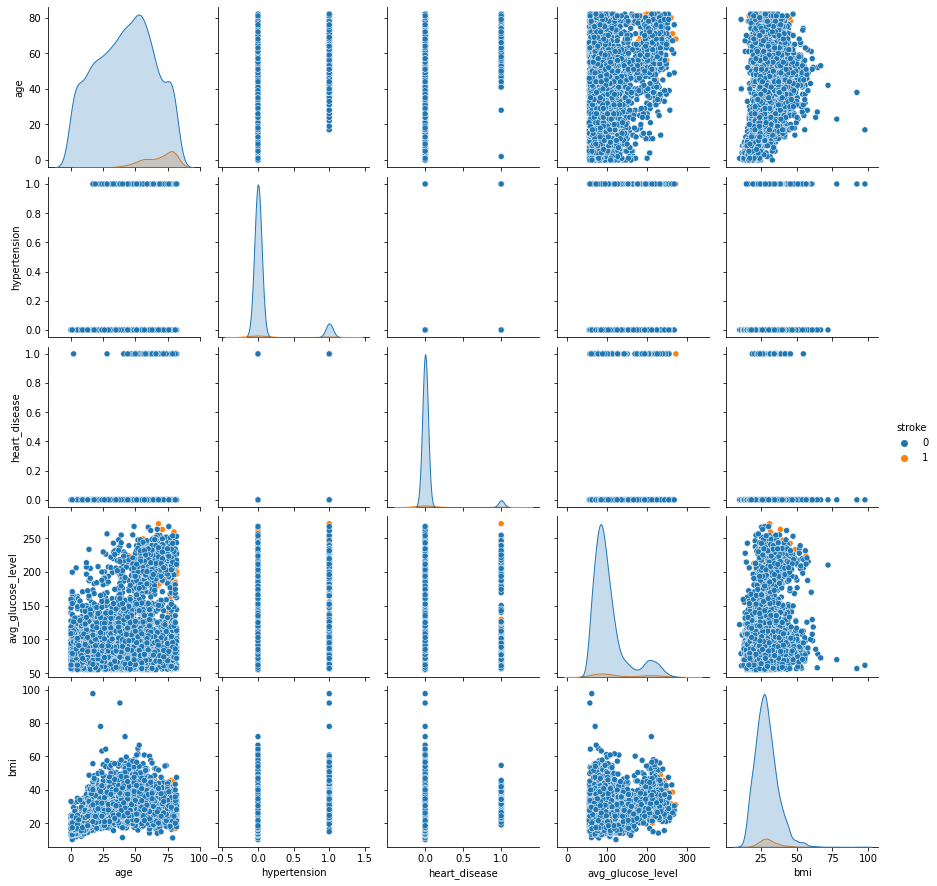

In [10]:
import seaborn as sns
sns.pairplot(df, hue='stroke')

In [6]:
def plot_validation_curve(param_range, train_scores, test_scores, x_label, title, alpha=0.1):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, color='blue', alpha=alpha)
    plt.plot(param_range, test_mean, label='validation score', color='red', marker='o')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, color='red', alpha=alpha)
    plt.title(title)
    plt.grid(ls='--')
    plt.xlabel(x_label)
    plt.ylabel('PR_Auc score')
    plt.legend(loc='best')
    plt.show()


In [7]:
def plot_train_time_curve(train_sizes, fit_times, title, alpha=0.1):
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    plt.plot(train_sizes, fit_times_mean, label='train points', color='blue', marker='o')
    plt.fill_between(train_sizes, fit_times_mean + fit_times_std,
                     fit_times_mean - fit_times_std, color='blue', alpha=alpha)
    plt.title(title)
    plt.xlabel('Number of training points')
    plt.ylabel('Training time')
    plt.grid(ls='--')
    plt.legend(loc='best')
    plt.show()

In [8]:
def plot_learning_curve(train_sizes, train_scores, test_scores, title, alpha=0.1):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean + train_std,
                     train_mean - train_std, color='blue', alpha=alpha)
    plt.plot(train_sizes, test_mean, label='validation score', color='red', marker='o')

    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='red', alpha=alpha)
    plt.title(title)
    plt.xlabel('Number of training points')
    plt.ylabel('PR_Auc score')
    plt.grid(ls='--')
    plt.legend(loc='best')
    plt.show()


In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve,validation_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn import svm
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=40)

scaler= MinMaxScaler()
one_hot_encoder=OneHotEncoder()

numercial_cols=['age', 'bmi', 'avg_glucose_level']
catergorical_cols=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

data_prep=make_column_transformer((make_pipeline(scaler), numercial_cols),
                                  (make_pipeline(one_hot_encoder), catergorical_cols),
                                  remainder="passthrough")
s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
print(X_test.shape)



(1473, 10)


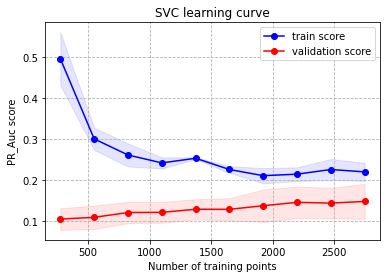

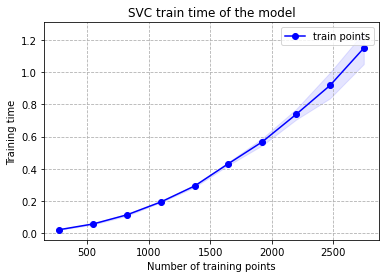

SVC: PR-Auc= 0.158
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1410
           1       0.11      0.73      0.19        63

    accuracy                           0.74      1473
   macro avg       0.55      0.73      0.52      1473
weighted avg       0.95      0.74      0.81      1473

[[1037  373]
 [  17   46]]


In [10]:
pipeline = make_pipeline(data_prep,svm.SVC(kernel='rbf',random_state=40,class_weight='balanced',probability =True))

train_sizes, train_scores, test_scores,fit_times, _  = learning_curve(estimator=pipeline, X=X_train, y=y_train,
                                                       cv=s_kfold,  scoring='average_precision',
                                                       train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1,return_times=True)
                                                        

plot_learning_curve(train_sizes, train_scores, test_scores,'SVC learning curve')
plot_train_time_curve(train_sizes, fit_times, 'SVC train time of the model')

from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix,roc_auc_score
pipeline.fit(X_train, y_train)

# calculate pr auc
y_pred = pipeline.predict(X_test)
yhat = pipeline.predict_proba(X_test)
pos_probs = yhat[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, pos_probs)
# summarize scores
print('SVC: PR-Auc= %.3f' %  auc(lr_recall, lr_precision))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [12]:
pipeline[1].get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 40,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 40, 'shrinking': True, 'tol': 0.001, 'verbose': False}


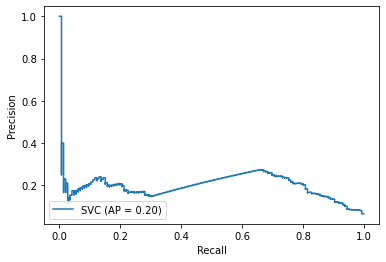

In [16]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(pipeline, X_train, y_train, name='SVC')
print(pipeline.steps[1][1].get_params())

In [28]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
pipeline = make_pipeline(data_prep,svm.SVC(random_state=40,class_weight='balanced',probability =True))
C = list(np.arange(.1, 10, 0.5))
gamma_range = list(np.arange(.1, 10, .5))
parameters = dict(svc__C=C,svc__gamma=gamma_range)
grid_search_cv = GridSearchCV(pipeline, parameters,cv=s_kfold, scoring='average_precision',n_jobs=-1)
random_search_cv = RandomizedSearchCV(pipeline, parameters,cv=s_kfold,n_iter=50,scoring='average_precision',n_jobs=-1)
grid_search_cv.fit(X_train, y_train)
print("Tuned SVC best params: {}".format(grid_search_cv.best_params_))



Tuned SVC best params: {'svc__C': 0.1, 'svc__gamma': 0.1}


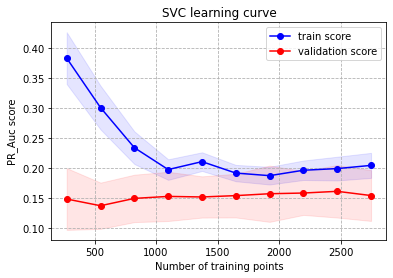

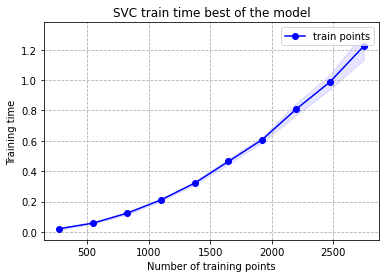

SVC: Predict Time= 0.136
SVC: PR-Auc= 0.181
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1410
           1       0.11      0.79      0.20        63

    accuracy                           0.72      1473
   macro avg       0.55      0.76      0.51      1473
weighted avg       0.95      0.72      0.80      1473

[[1011  399]
 [  13   50]]


In [11]:
pipeline = make_pipeline(data_prep,svm.SVC(kernel='rbf',C=2.1, gamma=0.1,random_state=40,class_weight='balanced',probability =True))

train_sizes, train_scores, test_scores,fit_times, _  = learning_curve(estimator=pipeline, X=X_train, y=y_train,
                                                       cv=s_kfold,  scoring='average_precision',
                                                       train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1,return_times=True)
                                                        

plot_learning_curve(train_sizes, train_scores, test_scores,'SVC learning curve')
plot_train_time_curve(train_sizes, fit_times, 'SVC train time best of the model')

from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix,roc_auc_score
pipeline.fit(X_train, y_train)

# calculate pr auc
import time
start = time.time()
y_pred = pipeline.predict(X_test)
yhat = pipeline.predict_proba(X_test)
diff=time.time() - start
print('SVC: Predict Time= %.3f' %  diff)
pos_probs = yhat[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, pos_probs)
# summarize scores
print('SVC: PR-Auc= %.3f' %  auc(lr_recall, lr_precision))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [67]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
pipeline = make_pipeline(data_prep,svm.SVC(kernel='poly',random_state=40,class_weight='balanced',probability =True))
C = list(np.arange(.1, 10, .5))
parameters = dict(svc__C=C)
#grid_search_cv = GridSearchCV(pipeline, parameters,cv=s_kfold, scoring='average_precision')
random_search_cv = RandomizedSearchCV(pipeline, parameters,cv=s_kfold,n_iter=50,scoring='average_precision',n_jobs=-1)
random_search_cv.fit(X_train, y_train)
print("Tuned SVC best params: {}".format(random_search_cv.best_params_))



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuned SVC best params: {'svc__C': 0.1}


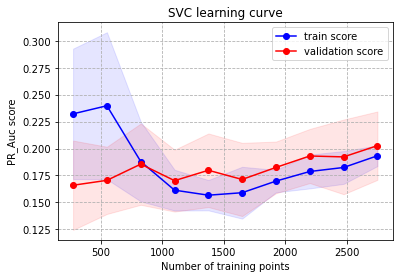

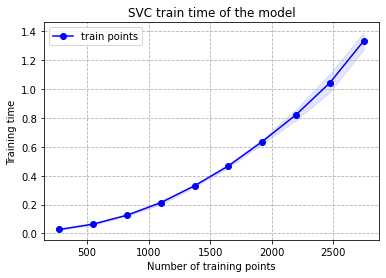

SVC: PR-Auc= 0.190
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1410
           1       0.12      0.84      0.21        63

    accuracy                           0.73      1473
   macro avg       0.55      0.78      0.52      1473
weighted avg       0.95      0.73      0.81      1473

[[1015  395]
 [  10   53]]


In [69]:
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix
pipeline = make_pipeline(data_prep,svm.SVC(kernel='poly',degree=1,C=1,random_state=40,class_weight='balanced',probability =True))

train_sizes, train_scores, test_scores,fit_times, _  = learning_curve(estimator=pipeline, X=X_train, y=y_train,
                                                       cv=s_kfold,  scoring='average_precision',
                                                       train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1,return_times=True)
                                                        

plot_learning_curve(train_sizes, train_scores, test_scores,'SVC learning curve')
plot_train_time_curve(train_sizes, fit_times, 'SVC train time of best the model')

from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix,roc_auc_score
pipeline.fit(X_train, y_train)

# calculate pr auc
import time
start = time.time()
y_pred = pipeline.predict(X_test)
yhat = pipeline.predict_proba(X_test)
diff=time.time() - start
print('SVC: Predict Time= %.3f' %  diff)
pos_probs = yhat[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, pos_probs)
# summarize scores
print('SVC: PR-Auc= %.3f' %  auc(lr_recall, lr_precision))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [64]:
pipeline[1].get_params()

{'C': 0.5,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 1,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': True,
 'random_state': 40,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

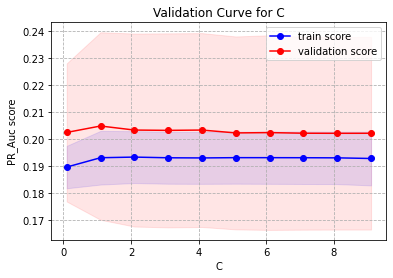

In [34]:
from sklearn.model_selection import validation_curve
C = list(np.arange(.1, 10, 1))
train_scores, test_scores = validation_curve(
        estimator=pipeline, X=X_train, y=y_train, param_name="svc__C", param_range=C,
        cv=s_kfold, scoring="average_precision", n_jobs=-1)
plot_validation_curve(C, train_scores, test_scores, 'C', title="Validation Curve for C",alpha=0.1)

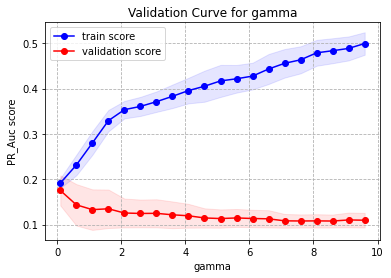

In [35]:
from sklearn.model_selection import validation_curve
pipeline = make_pipeline(data_prep,svm.SVC(random_state=40,class_weight='balanced',probability =True,C=0.1))
gamma_range = list(np.arange(.1, 10, .5))
train_scores, test_scores = validation_curve(
        estimator=pipeline, X=X_train, y=y_train, param_name="svc__gamma", param_range=gamma_range,
        cv=s_kfold, scoring="average_precision", n_jobs=-1)
plot_validation_curve(gamma_range, train_scores, test_scores, 'gamma', title="Validation Curve for gamma", alpha=0.1)

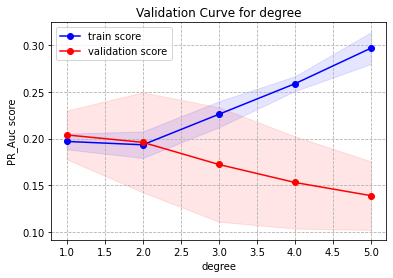

In [70]:
from sklearn.model_selection import validation_curve
pipeline = make_pipeline(data_prep,svm.SVC(kernel='poly',random_state=40,class_weight='balanced',probability =True,C=0.1))
degree = list(np.arange(1, 6, 1))
train_scores, test_scores = validation_curve(
        estimator=pipeline, X=X_train, y=y_train, param_name="svc__degree", param_range=degree,
        cv=s_kfold, scoring="average_precision", n_jobs=-1)
plot_validation_curve(degree, train_scores, test_scores, 'degree', title="Validation Curve for degree",alpha=0.1)